# **Ingredient Classifier**


In [1]:
import requests, re, time
import torch, torchvision
from torch import nn, optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Uploading Datasets

In [3]:
os.makedirs("./datasets/", exist_ok=True)

In [4]:
#copy zipped datasets from drive to VM
%cp -av "/content/drive/MyDrive/ingredient_datasets/" "/content/datasets/"

'/content/drive/MyDrive/ingredient_datasets/' -> '/content/datasets/ingredient_datasets'
'/content/drive/MyDrive/ingredient_datasets/ingredient_datasets.zip' -> '/content/datasets/ingredient_datasets/ingredient_datasets.zip'


In [ ]:
!unzip "./datasets/ingredient_datasets/ingredient_datasets.zip" -d "./datasets"

In [6]:
!rm -rf "./datasets/ingredient_datasets/"

In [ ]:
#For uploading dataset from google drive
xform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
dataset_full = datasets.ImageFolder('./drive/MyDrive/dataset', transform=xform)

In [ ]:
#For extracting dataset from zip file uploaded locally
for filename in os.listdir("./datasets/"):
    currfile = os.path.join('./datasets/', filename)
    !unzip "$currfile"
    #!rm -rf "$currfile"
    #!mv "$currfile" "./datasets/"

Training Classifier

In [7]:
#For uploading dataset locally
xform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
dataset_full = datasets.ImageFolder('./datasets/', transform=xform)

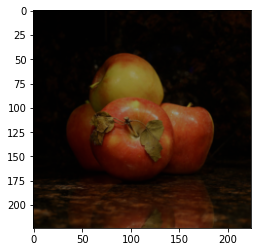

In [25]:
#Check to make sure dataset is correct
plt.imshow(dataset_full[1][0].permute(1,2,0))

In [37]:
n_all = len(dataset_full)
n_train = int(0.8 * n_all)
n_test = n_all - n_train
rng = torch.Generator().manual_seed(1549)
dataset_train, dataset_test = torch.utils.data.random_split(dataset_full, [n_train, n_test], rng)

In [38]:
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size = 4, shuffle=True)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size = 4, shuffle=True)

In [39]:
model = models.resnet18(pretrained=True)

In [40]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [41]:
model.fc = nn.Linear(model.fc.in_features, 26)
torch.nn.init.xavier_uniform_(model.fc.weight)

Parameter containing:
tensor([[-0.0383, -0.0584,  0.0190,  ..., -0.0947, -0.0962,  0.0301],
        [-0.0536, -0.0539,  0.0765,  ...,  0.1023, -0.0924, -0.0006],
        [ 0.0528, -0.0372, -0.0267,  ...,  0.0372, -0.1026,  0.0390],
        ...,
        [ 0.0346,  0.0718,  0.0731,  ...,  0.0846,  0.0784,  0.0839],
        [ 0.0686,  0.0140, -0.0614,  ...,  0.0136,  0.0163, -0.0898],
        [ 0.0894,  0.0535, -0.0639,  ..., -0.0806,  0.0206,  0.0245]],
       requires_grad=True)

In [42]:
torch.cuda.device_count()
device = torch.device('cuda:0')
#device = torch.device('cpu')
model = model.to(device)

In [43]:
criterion = nn.CrossEntropyLoss()

def run_test(model):
    nsamples_test = len(dataset_test)
    loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for samples, labels in loader_test:
            #print(labels)
            #labels = [l-1 for l in labels]
            #print(labels)
            samples = samples.to(device)
            labels = labels.to(device)
            outs = model(samples)
            loss += criterion(outs, labels)
            _, preds = torch.max(outs.detach(), 1)
            correct_mask = preds == labels
            correct += correct_mask.sum(0).item()
    return loss / nsamples_test, correct / nsamples_test

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# **Augmentation Tests**

To try and improve accuracy, we experimented with different transforms for the training dataset and we also tried using SGD, Adam, and Adam W as our optimizer, with varying values for lr and weight-decay

In [16]:
#Trying Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.02, amsgrad=False)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
#Trying Adam optimizer w/ lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.02, amsgrad=False)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
#Trying AdamW optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [44]:
#Trying AdamW optimizer w/ weight_decay=0.02
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.02, amsgrad=False)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
#Trying AdamW optimizer w/ weight_decay=0.03
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.03, amsgrad=False)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
#Trying AdamW optimizer w/ lr=0.001 - Best Result
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.02, amsgrad=False)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [36]:
#Trying different transformations
#xform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Grayscale(num_output_channels = 3), transforms.RandomHorizontalFlip()])
xform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.RandomHorizontalFlip(), transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0)])
dataset_full = datasets.ImageFolder('./datasets/', transform=xform)

In [45]:
def run_train(model, opt, sched):
    nsamples_train = len(dataset_train)
    loss_sofar, correct_sofar = 0, 0
    model.train()
    with torch.enable_grad():
        for samples, labels in loader_train:
            samples = samples.to(device)
            labels = labels.to(device)
            opt.zero_grad()
            outs = model(samples)
            _, preds = torch.max(outs.detach(), 1)
            loss = criterion(outs, labels)
            loss.backward()
            opt.step()
            loss_sofar += loss.item() * samples.size(0)
            correct_sofar += torch.sum(preds == labels.detach())
    sched.step()
    return loss_sofar / nsamples_train, correct_sofar / nsamples_train

In [46]:
def run_all(model, optimizer, scheduler, n_epochs):
    for epoch in range(n_epochs):
        loss_train, acc_train = run_train(model, optimizer, scheduler)
        loss_test, acc_test = run_test(model)
        print(f"epoch {epoch}: train loss {loss_train:.4f} acc {acc_train:.4f}, test loss {loss_test:.4f} acc {acc_test:.4f}")

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
run_test(model)

In [47]:
run_all(model, optimizer, scheduler, 10)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


epoch 0: train loss 1.4103 acc 0.6021, test loss 0.2295 acc 0.7566
epoch 1: train loss 0.9390 acc 0.7278, test loss 0.1986 acc 0.8032
epoch 2: train loss 0.7464 acc 0.7873, test loss 0.2090 acc 0.7995
epoch 3: train loss 0.6842 acc 0.8034, test loss 0.2164 acc 0.7958
epoch 4: train loss 0.5216 acc 0.8413, test loss 0.2147 acc 0.8087
epoch 5: train loss 0.3210 acc 0.9102, test loss 0.1382 acc 0.8657
epoch 6: train loss 0.2280 acc 0.9341, test loss 0.1404 acc 0.8688
epoch 7: train loss 0.1975 acc 0.9482, test loss 0.1319 acc 0.8780
epoch 8: train loss 0.1801 acc 0.9520, test loss 0.1389 acc 0.8694
epoch 9: train loss 0.1472 acc 0.9621, test loss 0.1505 acc 0.8627


# **Augmentation Tests Results:**

## **Changing Optimizers**

**Optimizer = SGD, transforms = default:**

epoch 0: train loss 1.6718 acc 0.5310, test loss 0.2414 acc 0.7351

epoch 1: train loss 1.0440 acc 0.7002, test loss 0.2048 acc 0.7799

epoch 2: train loss 0.7637 acc 0.7722, test loss 0.2001 acc 0.8087

epoch 3: train loss 0.5726 acc 0.8287, test loss 0.1996 acc 0.8112

epoch 4: train loss 0.4477 acc 0.8632, test loss 0.2276 acc 0.8001

epoch 5: train loss 0.2093 acc 0.9404, test loss 0.1522 acc 0.8578

epoch 6: train loss 0.1431 acc 0.9615, test loss 0.1537 acc 0.8584

epoch 7: train loss 0.1232 acc 0.9661, test loss 0.1535 acc 0.8657

epoch 8: train loss 0.1219 acc 0.9670, test loss 0.1466 acc 0.8688

epoch 9: train loss 0.0883 acc 0.9787, test loss 0.1465 acc 0.8688


**Optimizer: AdamW (lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False), transforms: default**

epoch 0: train loss 0.9976 acc 0.6932, test loss 0.3391 acc 0.6180

epoch 1: train loss 0.9813 acc 0.6926, test loss 0.3397 acc 0.6248

epoch 2: train loss 0.9696 acc 0.6966, test loss 0.3462 acc 0.6162

epoch 3: train loss 0.9884 acc 0.6958, test loss 0.3370 acc 0.6223

epoch 4: train loss 0.9605 acc 0.7045, test loss 0.3393 acc 0.6217

epoch 5: train loss 0.9732 acc 0.7021, test loss 0.3258 acc 0.6401

epoch 6: train loss 0.9795 acc 0.6886, test loss 0.3400 acc 0.6291

epoch 7: train loss 0.9790 acc 0.6967, test loss 0.3308 acc 0.6248

epoch 8: train loss 0.9897 acc 0.6935, test loss 0.3391 acc 0.6143

epoch 9: train loss 0.9809 acc 0.6923, test loss 0.3349 acc 0.6235



### ***Best Result:*** **Optimizer: AdamW (lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.02, amsgrad=False), transforms: default**

epoch 0: train loss 1.3150 acc 0.6242, test loss 0.1857 acc 0.8069

epoch 1: train loss 0.7463 acc 0.7841, test loss 0.1578 acc 0.8369

epoch 2: train loss 0.5395 acc 0.8399, test loss 0.2000 acc 0.8283

epoch 3: train loss 0.4192 acc 0.8784, test loss 0.1971 acc 0.8142

epoch 4: train loss 0.3450 acc 0.8982, test loss 0.2051 acc 0.8302

epoch 5: train loss 0.1828 acc 0.9503, test loss 0.1457 acc 0.8645

epoch 6: train loss 0.1115 acc 0.9692, test loss 0.1500 acc 0.8663

epoch 7: train loss 0.0929 acc 0.9756, test loss 0.1391 acc 0.8780

epoch 8: train loss 0.0746 acc 0.9816, test loss 0.1367 acc 0.8780

epoch 9: train loss 0.0633 acc 0.9856, test loss 0.1432 acc 0.8731

**Optimizer: AdamW (lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.03, amsgrad=False), transforms: default**

epoch 0: train loss 0.2442 acc 0.9287, test loss 0.2380 acc 0.8130

epoch 1: train loss 0.2471 acc 0.9253, test loss 0.2236 acc 0.8277

epoch 2: train loss 0.2248 acc 0.9358, test loss 0.2005 acc 0.8314

epoch 3: train loss 0.1856 acc 0.9459, test loss 0.2190 acc 0.8155

epoch 4: train loss 0.1689 acc 0.9531, test loss 0.2023 acc 0.8283

epoch 5: train loss 0.1095 acc 0.9683, test loss 0.1662 acc 0.8504

epoch 6: train loss 0.0627 acc 0.9830, test loss 0.1650 acc 0.8547

epoch 7: train loss 0.0566 acc 0.9854, test loss 0.1624 acc 0.8578

epoch 8: train loss 0.0479 acc 0.9859, test loss 0.1626 acc 0.8571

epoch 9: train loss 0.0398 acc 0.9890, test loss 0.1604 acc 0.8670

**Optimizer: AdamW (lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.02), amsgrad=False), transforms: default**

epoch 0: train loss 2.3710 acc 0.3347, test loss 0.5864 acc 0.4733

epoch 1: train loss 1.7789 acc 0.4707, test loss 0.5390 acc 0.5573

epoch 2: train loss 1.5385 acc 0.5472, test loss 0.4112 acc 0.5929

epoch 3: train loss 1.3093 acc 0.6067, test loss 0.4463 acc 0.6070

epoch 4: train loss 1.0990 acc 0.6711, test loss 0.2907 acc 0.6885

epoch 5: train loss 0.5097 acc 0.8485, test loss 0.2257 acc 0.7658

epoch 6: train loss 0.3249 acc 0.9060, test loss 0.2204 acc 0.7725

epoch 7: train loss 0.2408 acc 0.9348, test loss 0.2312 acc 0.7633

epoch 8: train loss 0.1912 acc 0.9453, test loss 0.2314 acc 0.7658

epoch 9: train loss 0.1370 acc 0.9641, test loss 0.2373 acc 0.7621

**Optimizer: Adam(lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.02, amsgrad=False), transforms: default**

epoch 0: train loss 1.4028 acc 0.6069, test loss 0.2529 acc 0.7511

epoch 1: train loss 1.0536 acc 0.7045, test loss 0.2523 acc 0.7400

epoch 2: train loss 1.0158 acc 0.7081, test loss 0.2868 acc 0.7572

epoch 3: train loss 0.9804 acc 0.7196, test loss 0.3120 acc 0.7590

epoch 4: train loss 0.9717 acc 0.7234, test loss 0.3033 acc 0.7088

epoch 5: train loss 0.5186 acc 0.8760, test loss 0.1572 acc 0.8406

epoch 6: train loss 0.3411 acc 0.9233, test loss 0.1362 acc 0.8602

epoch 7: train loss 0.2688 acc 0.9456, test loss 0.1316 acc 0.8627

epoch 8: train loss 0.2196 acc 0.9603, test loss 0.1436 acc 0.8522

epoch 9: train loss 0.1773 acc 0.9733, test loss 0.1357 acc 0.8547

**Optimizer: AdamW(lr=0.00001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.02, amsgrad=False, transforms: default**

epoch 0: train loss 0.1575 acc 0.9741, test loss 0.1323 acc 0.8639

epoch 1: train loss 0.1219 acc 0.9831, test loss 0.1430 acc 0.8639

epoch 2: train loss 0.1163 acc 0.9818, test loss 0.1404 acc 0.8565

epoch 3: train loss 0.1005 acc 0.9859, test loss 0.1309 acc 0.8657

epoch 4: train loss 0.0883 acc 0.9873, test loss 0.1430 acc 0.8639

epoch 5: train loss 0.0793 acc 0.9883, test loss 0.1497 acc 0.8522

epoch 6: train loss 0.0626 acc 0.9913, test loss 0.1383 acc 0.8633

epoch 7: train loss 0.0621 acc 0.9913, test loss 0.1327 acc 0.8645

epoch 8: train loss 0.0566 acc 0.9925, test loss 0.1379 acc 0.8590

epoch 9: train loss 0.0497 acc 0.9931, test loss 0.1284 acc 0.8682

## **Changing Transforms**


**Optimizer: SGD, transforms: grayscale, randomHorizontalFlip**

epoch 0: train loss 2.0609 acc 0.4333, test loss 0.4489 acc 0.5395

epoch 1: train loss 1.4309 acc 0.5986, test loss 0.3648 acc 0.6401

epoch 2: train loss 1.1977 acc 0.6544, test loss 0.3711 acc 0.6628

epoch 3: train loss 0.9790 acc 0.7160, test loss 0.4514 acc 0.6113

epoch 4: train loss 0.8388 acc 0.7579, test loss 0.3057 acc 0.7161

epoch 5: train loss 0.4392 acc 0.8749, test loss 0.2166 acc 0.7866

epoch 6: train loss 0.3549 acc 0.8987, test loss 0.2112 acc 0.7971

epoch 7: train loss 0.3136 acc 0.9135, test loss 0.2134 acc 0.7897

**Optimizer: AdamW (lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.02, amsgrad=False), transforms: ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0) & RandomHorizontalFlip**

epoch 0: train loss 1.4103 acc 0.6021, test loss 0.2295 acc 0.7566

epoch 1: train loss 0.9390 acc 0.7278, test loss 0.1986 acc 0.8032

epoch 2: train loss 0.7464 acc 0.7873, test loss 0.2090 acc 0.7995

epoch 3: train loss 0.6842 acc 0.8034, test loss 0.2164 acc 0.7958

epoch 4: train loss 0.5216 acc 0.8413, test loss 0.2147 acc 0.8087

epoch 5: train loss 0.3210 acc 0.9102, test loss 0.1382 acc 0.8657

epoch 6: train loss 0.2280 acc 0.9341, test loss 0.1404 acc 0.8688

epoch 7: train loss 0.1975 acc 0.9482, test loss 0.1319 acc 0.8780

epoch 8: train loss 0.1801 acc 0.9520, test loss 0.1389 acc 0.8694

epoch 9: train loss 0.1472 acc 0.9621, test loss 0.1505 acc 0.8627

**identify_sample Function:**

Takes path to a folder of samples and outputs a tensor containing the labels (0-26) of the ingredient in each image sample as predicted by our classifier

*   Input: path = path to folder, where the samples to identify are contained in a separate folder
*   Output: tensor with predicted labels for each sample in path



In [ ]:
def identify_sample(path):
  model.eval()
  inputs = datasets.ImageFolder(path, transform=xform)

  for r in range(len(inputs)):
    #for c in range(len(inputs[r])):
    plt.figure()
    plt.imshow(inputs[r][0].permute(1,2,0))

  loader = torch.utils.data.DataLoader(inputs, batch_size = 4, shuffle=True)
  with torch.no_grad():
    for samples,_ in loader:
      samples = samples.to(device)
      outs = model(samples)
      _, preds = torch.max(outs.detach(), 1)
      print(preds)
      return preds

tensor([ 9,  6, 19, 19], device='cuda:0')


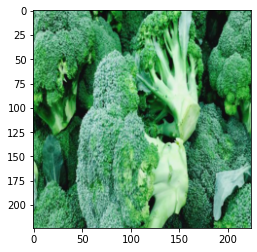

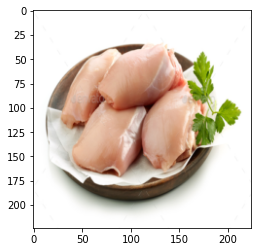

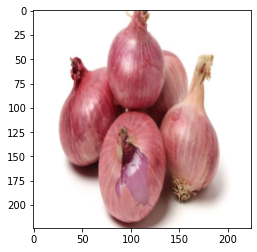

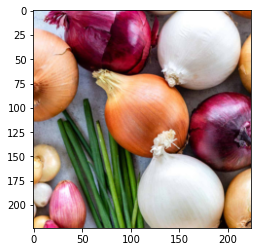

In [ ]:
identify_sample("./test/")